##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Building deep retrieval models

In [the featurization tutorial](https://www.tensorflow.org/recommenders/examples/featurization) we incorporated multiple features into our models, but the models consist of only an embedding layer. We can add more dense layers to our models to increase their expressive power.

In general, deeper models are capable of learning more complex patterns than shallower models. For example, our [user model](https://www.tensorflow.org/recommenders/examples/featurization#user_model) incorporates user ids and timestamps to model user preferences at a point in time. A shallow model (say, a single embedding layer) may only be able to learn the simplest relationships between those features and movies: a given movie is most popular around the time of its release, and a given user generally prefers horror movies to comedies. To capture more complex relationships, such as user preferences evolving over time, we may need a deeper model with multiple stacked dense layers.

Of course, complex models also have their disadvantages. The first is computational cost, as larger models require both more memory and more computation to fit and serve. The second is the requirement for more data: in general, more training data is needed to take advantage of deeper models. With more parameters, deep models might overfit or even simply memorize the training examples instead of learning a function that can generalize. Finally, training deeper models may be harder, and more care needs to be taken in choosing settings like regularization and learning rate.

Finding a good architecture for a real-world recommender system is a complex art, requiring good intuition and careful [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization). For example, factors such as the depth and width of the model, activation function, learning rate, and optimizer can radically change the performance of the model. Modelling choices are further complicated by the fact that good offline evaluation metrics may not correspond to good online performance, and that the choice of what to optimize for is often more critical than the choice of model itself.

Nevertheless, effort put into building and fine-tuning larger models often pays off. In this tutorial, we will illustrate how to build deep retrieval models using TensorFlow Recommenders. We'll do this by building progressively more complex models to see how this affects model performance.

## Preliminaries

We first import the necessary packages.

In [2]:
import os
import tempfile
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs


from tqdm.notebook import tqdm
# utils
from utils import time_utils
from utils.display_dataframe import grid_df_display

# tensorboard needs
from tensorboard import notebook
import time
import subprocess
import platform
import os
import re
import datetime

plt.style.use('seaborn-whitegrid')

In this tutorial we will use the models from [the featurization tutorial](https://www.tensorflow.org/recommenders/examples/featurization) to generate embeddings. Hence we will only be using the user id, timestamp, and movie title features.

In [3]:
# Read the data
user_name = ['user_id', 'age', 'gender', 'user_occupation_text', 'user_zip_code']
user_df = pd.read_csv('../Data/ml-100k/u.user', sep='|', names=user_name)

ratings_name = ['user_id', 'movie_id', 'user_rating', 'timestamp']
ratings_df = pd.read_csv('../Data/ml-100k/u.data', sep='\t', names=ratings_name)

movies_name = ['movie_id', 'movie_title', 'release_data', 'video_release_date',
               'IMDb_URL', 'unknow', 'Action', 'Adventure', 'Animation', 'Children’s',
               'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
               'War', 'Western']
movies_df = pd.read_csv('../Data/ml-100k/u.item', sep='|', encoding='ISO-8859-1', header=None, names=movies_name)

In [4]:
grid_df_display(
    list_df = [user_df, ratings_df, movies_df],
    list_df_name = ['user_df', 'ratings_df', 'movies_df'],
    list_number_of_data = [5, 5, 5],
    row=2, col=2, fill='row'
)

We also do some housekeeping to prepare feature vocabularies.

In [5]:
hash_table = {'F':0, 'M':1}
user_df['user_gender'] = user_df['gender'].map(hash_table.get)

In [6]:
bins = [0, 18, 25, 35, 45, 50, 55, float('inf')]
user_df['user_bucketized_age'] = pd.cut(user_df['age'], bins, labels=[1, 18, 25, 35, 45, 50, 56], retbins=False)

In [7]:
user_df.head()

,user_id,age,gender,user_occupation_text,user_zip_code,user_gender,user_bucketized_age
0,1,24,M,technician,85711,1,18
1,2,53,F,other,94043,0,50
2,3,23,M,writer,32067,1,18
3,4,24,M,technician,43537,1,18
4,5,33,F,other,15213,0,25


In [8]:
ratings_df = pd.merge(ratings_df, movies_df, on='movie_id', how='left')
ratings_df = pd.merge(ratings_df, user_df, on='user_id', how='left')

In [9]:
ratings_df.head(3)

,user_id,movie_id,user_rating,timestamp,movie_title,release_data,video_release_date,IMDb_URL,unknow,Action,...,Sci-Fi,Thriller,War,Western,age,gender,user_occupation_text,user_zip_code,user_gender,user_bucketized_age
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,49,M,writer,55105,1,45
1,186,302,3,891717742,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,...,0,1,0,0,39,F,executive,00000,0,35
2,22,377,1,878887116,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,0,...,0,0,0,0,25,M,writer,40206,1,18


## Data processing

In [10]:
ratings_df = ratings_df.astype({'user_id': str, 'movie_id': str})

In [11]:
temp = ratings_df.groupby(['user_id'])['user_rating']
mins = temp.transform('min')
maxes = temp.transform('max')
# plus 0.01 is to avoid get the zero values
user_normalized_rating = ( (ratings_df['user_rating'] - mins) / maxes ) + 0.01
ratings_df['user_normalized_rating'] = user_normalized_rating

In [12]:
train_ratings_df = ratings_df.sort_values('timestamp').head(80000)
test_ratings_df = ratings_df.sort_values('timestamp').tail(20000)

In [13]:
train_ratings_df = train_ratings_df[['movie_title', 'user_id', 'timestamp', 'user_normalized_rating', 'user_gender', 'user_zip_code', 'user_occupation_text', 'user_bucketized_age']]
train_movies_df = pd.DataFrame(train_ratings_df['movie_title'].unique(), columns=['movie_title'])

In [14]:
# Select the basic features.
ratings = tf.data.Dataset.from_tensor_slices(dict(train_ratings_df)).map(lambda x: {
    'movie_title': x['movie_title'],
    'user_id': x['user_id'],
    'user_timestamp': x['timestamp'],
    'user_normalized_rating': x['user_normalized_rating'],
    'user_gender': x['user_gender'],
    'user_zip_code': x['user_zip_code'],
    'user_occupation_text': x['user_occupation_text'],
    'user_bucketized_age': x['user_bucketized_age'],
})

movies = tf.data.Dataset.from_tensor_slices(dict(train_movies_df)).map(lambda x: x['movie_title'])

In [15]:
# 透過 tensorflow 的 batch 函數，將每一組 tensor 裡的值，轉化成含有一個 array 的 tensor
# 再透過 list 函數得到迭代結果，並透過 np.concatenate 函數將資料整成一個 array
user_timestamp = np.concatenate(list(ratings.map(lambda x: x['user_timestamp']).batch(1_000)))

max_timestamp = user_timestamp.max()
min_timestamp = user_timestamp.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1_000,
)

user_normalized_rating = np.concatenate(list(
    ratings.map(lambda x: x['user_normalized_rating']).batch(1_000)
))


unique_user_gender = np.unique(np.concatenate(list(
    ratings.map(lambda x: x['user_gender']).batch(1_000)
)))


unique_user_zip_code = np.unique(np.concatenate(list(
    ratings.map(lambda x: x['user_zip_code']).batch(1_000)
)))


unique_user_occupation_text = np.unique(np.concatenate(list(
    ratings.map(lambda x: x['user_occupation_text']).batch(1_000)
)))


unique_user_bucketized_age = np.unique(np.concatenate(list(
    ratings.map(lambda x: x['user_bucketized_age']).batch(1_000)
)))


unique_movie_titles = np.unique(np.concatenate(list(
    movies.batch(1_000)
)))

unique_user_ids = np.unique(np.concatenate(list(
    ratings.batch(1_000).map(lambda x: x['user_id'])
)))

## Model definition
<div>
  <center>
    <img src='../Img/retrieval_model.PNG' width='50%' style='display:block' title='retrieval model'>
  </center>
</div>

### Query model

We start with the user model defined in [the featurization tutorial](featurization) as the first layer of our model, tasked with converting raw input examples into feature embeddings.

In [16]:
class UserModel(tf.keras.Model):
  
    def __init__(self):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
        ])

        # 先將 timestamp 區間化，然後再透過區間化後的 index 轉成 embedding 向量
        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
        ])

        # 直接將 timestamp 標準化
        self.normalized_timestamp = tf.keras.layers.Normalization(
            axis=None
        )
        # 當你需要標準化參數時，你會需要完整的資料，所以這時可以透過 adapt() 這個函數來讓我們的 layer 獲得初始化得參數
        self.normalized_timestamp.adapt(user_timestamp)

        # user_gender
        self.gender_one_hot = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(
                vocabulary=unique_user_gender, mask_token=None),
            tf.keras.layers.Embedding(
                len(unique_user_gender)+1,
                len(unique_user_gender),
                embeddings_initializer='identity')  # use one-hot method to create embedding layer
        ])


        # user_zip_code
        self.zip_code_one_hot = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_zip_code,
                mask_token=None),
            tf.keras.layers.Embedding(
                len(unique_user_zip_code)+1,  # input dimension
                len(unique_user_zip_code),  # output dimension
                embeddings_initializer='identity')  # use one-hot method to create embedding layer
        ])


        # user_occupation_text
        self.occupation_text_one_hot = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_user_occupation_text, mask_token=None),
            tf.keras.layers.Embedding(
                len(unique_user_occupation_text)+1,
                32
            )  
        ])


        # user_bucketized_age
        self.bucketized_age_one_hot = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(
                vocabulary=unique_user_bucketized_age, mask_token=None),
            tf.keras.layers.Embedding(
                len(unique_user_bucketized_age)+1,
                len(unique_user_bucketized_age),
                embeddings_initializer='identity')  # use one-hot method to create embedding layer
        ])

    
    
    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat([
            self.user_embedding(inputs['user_id']),
            tf.reshape(inputs['user_normalized_rating'], (-1, 1)),
            self.timestamp_embedding(inputs['user_timestamp']),
            tf.reshape(self.normalized_timestamp(inputs['user_timestamp']), (-1, 1)),
            self.gender_one_hot(inputs['user_gender']),
            self.zip_code_one_hot(inputs['user_zip_code']),
            self.occupation_text_one_hot(inputs['user_occupation_text']),
            self.bucketized_age_one_hot(inputs['user_bucketized_age'])
        ], axis=1)
    

Defining deeper models will require us to stack mode layers on top of this first input. A progressively narrower stack of layers, separated by an activation function, is a common pattern:

```
                            +----------------------+
                            |      128 x 64        |
                            +----------------------+
                                       | relu
                          +--------------------------+
                          |        256 x 128         |
                          +--------------------------+
                                       | relu
                        +------------------------------+
                        |          ... x 256           |
                        +------------------------------+
```
Since the expressive power of deep linear models is no greater than that of shallow linear models, we use ReLU activations for all but the last hidden layer. The final hidden layer does not use any activation function: using an activation function would limit the output space of the final embeddings and might negatively impact the performance of the model. For instance, if ReLUs are used in the projection layer, all components in the output embedding would be non-negative.

We're going to try something similar here. To make experimentation with different depths easy, let's define a model whose depth (and width) is defined by a set of constructor parameters. 

In [17]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes):
        """Model for encoding user queries.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation='relu'))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

The `layer_sizes` parameter gives us the depth and width of the model. We can vary it to experiment with shallower or deeper models.

### Candidate model

We can adopt the same approach for the movie model. Again, we start with the `MovieModel` from the [featurization](featurization) tutorial:

In [18]:
class MovieModel(tf.keras.Model):
  
    def __init__(self):
        super().__init__()

        max_tokens = 10_000  # item unique 的數量

        self.title_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_movie_titles,mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
        ])
        
        # A preprocessing layer which maps text features to integer sequences.
        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=max_tokens)

        self.title_text_embedding = tf.keras.Sequential([
            self.title_vectorizer,
            tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.title_vectorizer.adapt(movies)

    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles),
        ], axis=1)

And expand it with hidden layers:

In [19]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""

    def __init__(self, layer_sizes):
        """Model for encoding movies.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        self.embedding_model = MovieModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]: # 最後一層
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

### Combined model

With both `QueryModel` and `CandidateModel` defined, we can put together a combined model and implement our loss and metrics logic. To make things simple, we'll enforce that the model structure is the same across the query and candidate models.

In [20]:
class MovielensModel(tfrs.models.Model):

    def __init__(self, layer_sizes):
        super().__init__()
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, features, training=False):
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        query_embeddings = self.query_model({
            'user_id': features['user_id'],
            'user_normalized_rating': features['user_normalized_rating'],
            'user_timestamp': features['user_timestamp'],
            'user_gender': features['user_gender'],
            'user_zip_code': features['user_zip_code'],
            'user_occupation_text': features['user_occupation_text'],
            'user_bucketized_age': features['user_bucketized_age'],
        })
        movie_embeddings = self.candidate_model(features['movie_title'])

        return self.task(
            query_embeddings, movie_embeddings, compute_metrics=not training)

## Training the model

### Prepare the data

We first split the data into a training set and a testing set.

In [21]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(80_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(70_000)
val = shuffled.skip(70_000).take(10_000)

cached_train = train.shuffle(70_000).batch(2048)
cached_val = val.batch(4096).cache()
print('ratings: ', len(ratings))
print('cached_train: ', len(train))
print('cached_val: ', len(val))

ratings:  80000
cached_train:  70000
cached_val:  10000


### Shallow model

We're ready to try out our first, shallow, model!

In [22]:
num_epochs = 300

model = MovielensModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_val,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0,
    # callbacks=[early_stopping_monitor]
)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.30.


This gives us a top-100 accuracy of around 0.30. We can use this as a reference point for evaluating deeper models.

### Deeper model

What about a deeper model with two layers?

In [23]:
model = MovielensModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

two_layer_history = model.fit(
    cached_train,
    validation_data=cached_val,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.30.


The accuracy here is 0.29, quite a bit better than the shallow model.

We can plot the validation accuracy curves to illustrate this:

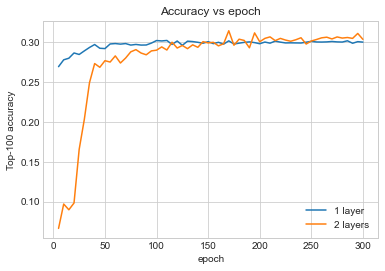

In [24]:
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

Even early on in the training, the larger model has a clear and stable lead over the shallow model, suggesting that adding depth helps the model capture more nuanced relationships in the data.

However, even deeper models are not necessarily better. The following model extends the depth to three layers:

In [25]:
model = MovielensModel([128, 64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

three_layer_history = model.fit(
    cached_train,
    validation_data=cached_val,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")


Top-100 accuracy: 0.23.


In fact, we don't see improvement over the shallow model:

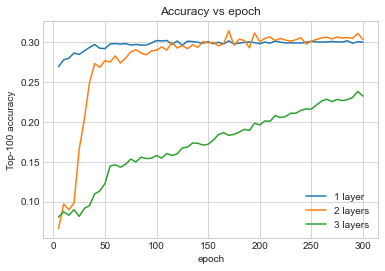

In [26]:
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

This is a good illustration of the fact that deeper and larger models, while capable of superior performance, often require very careful tuning. For example, throughout this tutorial we used a single, fixed learning rate. Alternative choices may give very different results and are worth exploring. 

With appropriate tuning and sufficient data, the effort put into building larger and deeper models is in many cases well worth it: larger models can lead to substantial improvements in prediction accuracy.



## Next Steps

In this tutorial we expanded our retrieval model with dense layers and activation functions. To see how to create a model that can perform not only retrieval tasks but also rating tasks, take a look at [the multitask tutorial](https://www.tensorflow.org/recommenders/examples/multitask).